In [69]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score


# **Cargando el df**

In [70]:
df = pd.read_csv('data/training_data.csv')

In [71]:
# Eliminado columnas innecesarias para la clusterización
df = df.drop(columns=['Unnamed: 0', 'InvoiceNo', 'InvoiceDate', 'CustomerID'], axis=1)

In [72]:
# Generando un filtrado para la clusterización
df_filtrado = df[['Recencia', 'Monto', 'Frecuencia']]

In [73]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer

# Estandarizar los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtrado)

df_scaled = pd.DataFrame(data=df_scaled, columns=df_filtrado.columns)

# **AgglomerativeClustering**

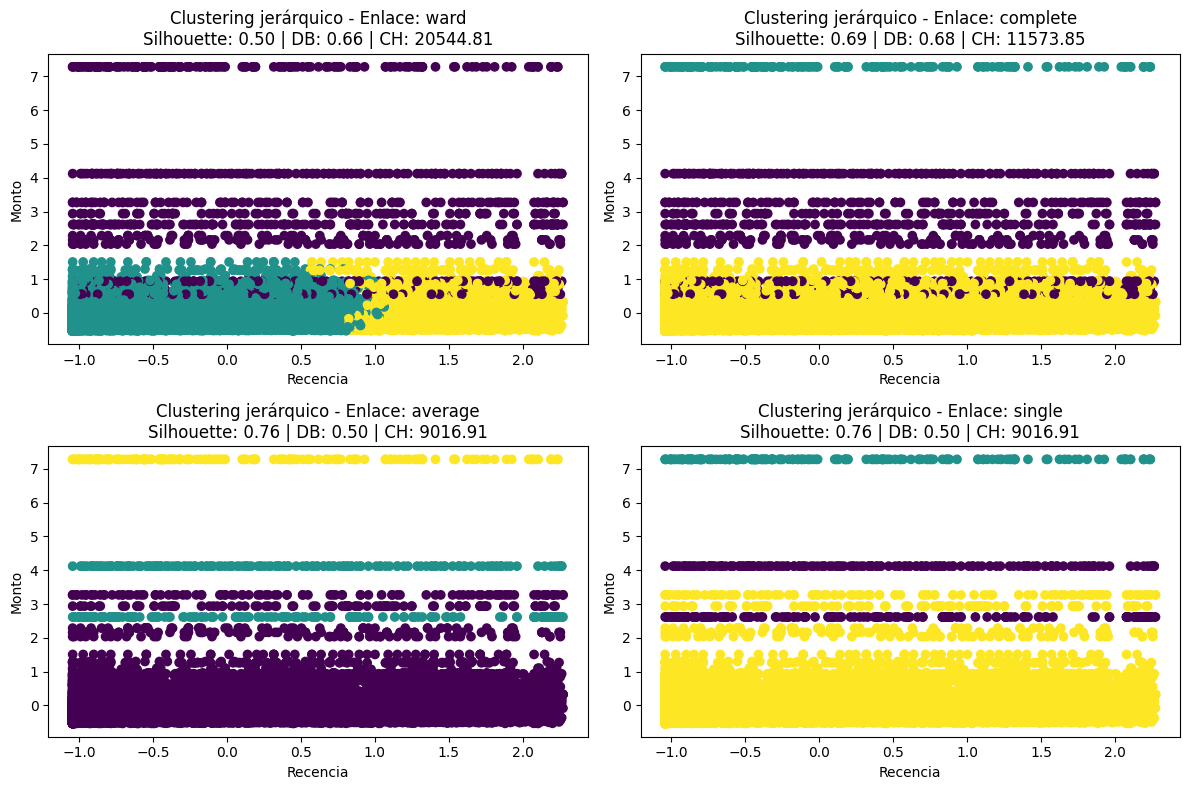

In [74]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score


results = dict()

# Seleccionar las columnas relevantes para el clustering jerárquico
X = df_scaled[['Recencia', 'Monto', 'Frecuencia']]

# Crear lista de métodos de enlace
linkage_methods = ['ward', 'complete', 'average', 'single']

# Configurar la visualización
plt.figure(figsize=(12, 8))

# Iterar sobre los métodos de enlace y realizar clustering jerárquico
for i, method in enumerate(linkage_methods):
    # Realizar clustering jerárquico con el método de enlace actual
    clustering = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = clustering.fit_predict(X)
    sc = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    results[f'Clustering jerárquico - Enlace: {method}'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}

    # Graficar los puntos en un diagrama de dispersión para las dos primeras columnas
    plt.subplot(2, 2, i+1)
    plt.scatter(X['Recencia'], X['Monto'], c=labels, cmap='viridis')
    plt.xlabel('Recencia')
    plt.ylabel('Monto')
    plt.title(f'Clustering jerárquico - Enlace: {method}\nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')




plt.tight_layout()
plt.show()

- En general todos los modelos se destacan por tener silhouette scoring medianamente altos, teniendo sus maximos en los dos ultimos modelos.
- El índice de davis el mínimo se encuentra también en los dos últimos modelos lo que nos indica que son los que mejor diferencian los distintos clusters
- Por otro lado el indice de calinski es más grande para los dos primeros clusters lo que puede indicar que se formaron cluster que no "están separados" o que tienen una mayor disperisón en alguna dimensión.}
- Lo malo que se puede ver que en general se ve que segmenta por monto
- Se ve prometedor el clustering con average


# **K-MEANS**

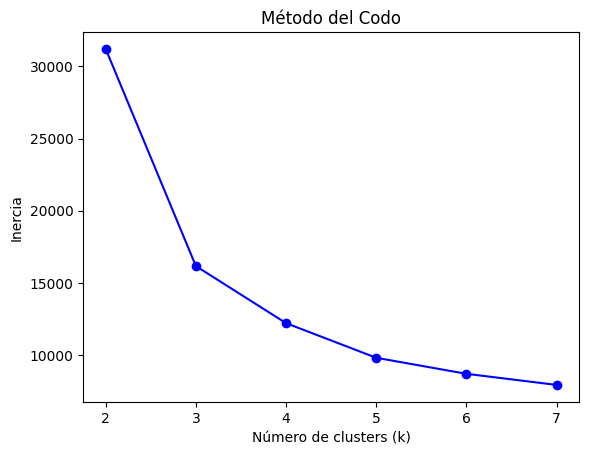

In [75]:


# Definir una lista de posibles valores de k para el método del codo
k_values = range(2, 8)

# Inicializar listas para almacenar las métricas
inertia_values = []

# Realizar clustering con diferentes valores de k y calcular las métricas
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    # Calcular la inercia
    inertia_values.append(kmeans.inertia_)
    

# Graficar el método del codo utilizando la inercia
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.show()

* Según nuestro gráfico el codo estaría ubicado en el k = 3

/tmp/ipykernel_167290/2912843864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Cluster_KMEANS'] = kmeans.fit_predict(df_scaled)


['Cluster 0', 'Cluster 2', 'Cluster 1']


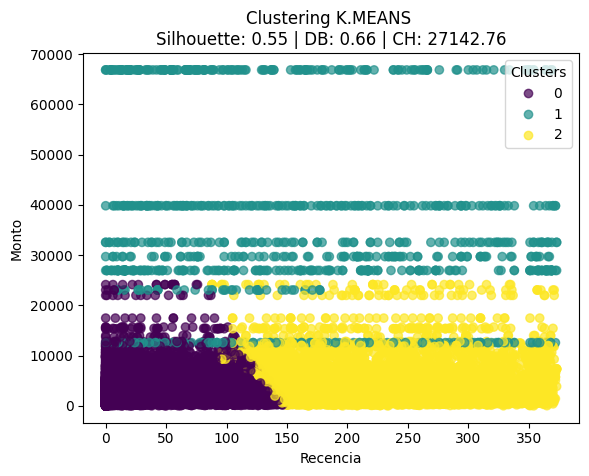

In [76]:
# Aplicar algoritmos de clustering (por ejemplo, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtrado['Cluster_KMEANS'] = kmeans.fit_predict(df_scaled)
sc = silhouette_score(X, df_filtrado['Cluster_KMEANS'] )
db_index = davies_bouldin_score(X, df_filtrado['Cluster_KMEANS'] )
ch_index = calinski_harabasz_score(X, df_filtrado['Cluster_KMEANS'] )
results[f'Clustering KMEANS'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}


# Visualizar los resultados
scatter = plt.scatter(df_filtrado['Recencia'], df_filtrado['Monto'], c=df_filtrado['Cluster_KMEANS'], cmap='viridis', alpha=0.7)
plt.xlabel('Recencia')
plt.ylabel('Monto')
plt.title(f'Clustering K.MEANS \nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')

# Obtener etiquetas únicas de los clusters
unique_labels = df_filtrado['Cluster_KMEANS'].unique()

# Generar etiquetas para la leyenda
legend_labels = [f'Cluster {label}' for label in unique_labels]
print(legend_labels)
# Agregar leyenda
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


- Tiene menor scoring en silhouette que los dos mejores de los clustering jerárquicos y además peor indice de davies, pero posee un calinski score gigante en comparación a todos los demas.

- Esto nos indica que aparte de segmentar por monto al parecer se encuentra segmentando por recencia
- En pocas palabras esta dividiendo por quien gasta más y después de los que gastan menos por quienes compraron más recientemente

In [77]:
df_resultados = pd.DataFrame(results)

df_resultados

,Clustering jerárquico - Enlace: ward,Clustering jerárquico - Enlace: complete,Clustering jerárquico - Enlace: average,Clustering jerárquico - Enlace: single,Clustering KMEANS
silhoutte_score,0.503963,0.687267,0.758016,0.758016,0.548006
davies_bouldin_score,0.656402,0.676323,0.498039,0.498039,0.658397
calinski_score,20544.808453,11573.849728,9016.909267,9016.909267,27142.762188


- Si tomamos los ulimos 3 clusterings podemos ver que Kmeans se desempeña significativamente peor que los dos anteiores a este. lo que si se puede ver que el indice de calinski se ve aumentado notoriamente avisando que tiene una mejor compactación y separación que los otros clusters

# **DB SCAN**

/tmp/ipykernel_140278/546811138.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)


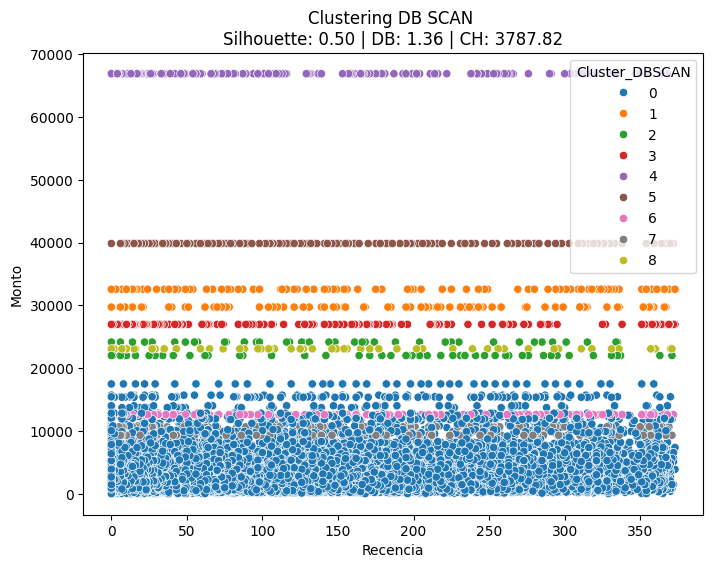

In [ ]:

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajusta eps y min_samples según sea necesario
df_filtrado["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)


sc = silhouette_score(X, df_filtrado['Cluster_DBSCAN'] )
db_index = davies_bouldin_score(X, df_filtrado['Cluster_DBSCAN'] )
ch_index = calinski_harabasz_score(X, df_filtrado['Cluster_DBSCAN'] )
results[f'Clustering KMEANS'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}


# Visualizar los resultados
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtrado.iloc[:, 0], y=df_filtrado.iloc[:, 1], hue=df_filtrado["Cluster_DBSCAN"], palette="tab10", legend="full")
plt.xlabel("Recencia")
plt.ylabel("Monto")
plt.title("DBSCAN")
plt.title(f'Clustering DB SCAN \nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')
plt.show()

- Posee un silhouette scoring de 0.5 lo que no es muy bueno. Ademas los indices de davies y calinski son bastante peores en relacion a los anteriores clusters

In [ ]:


# Definir rangos para eps y min_samples
eps_range = np.arange(0.1, 1.0, 0.1)  # Valores de eps
min_samples_range = range(3, 11)      # Valores de min_samples

# Variables para almacenar los mejores parámetros
best_score = -1
best_params = {"eps": None, "min_samples": None}

# GridSearch manual
for eps in eps_range:
    for min_samples in min_samples_range:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_scaled)
        
        # Ignorar configuraciones con un único clúster o todos ruido
        if len(set(labels)) <= 1 or (labels == -1).mean() == 1.0:
            continue
        
        # Calcular Silhouette Score
        score = silhouette_score(df_scaled, labels)
        
        # Guardar si es el mejor hasta ahora
        if score > best_score:
            best_score = score
            best_params = {"eps": eps, "min_samples": min_samples}

# Resultados
print("Mejor Silhouette Score:", best_score)
print("Mejores parámetros:", best_params)

Mejor Silhouette Score: 0.49956146449780064
Mejores parámetros: {'eps': np.float64(0.4), 'min_samples': 3}


- Considerando que el silhouette scoring es casi el mismo no veo el punto de volver a calcular mas metricas o generar otro DBSCAN

## **Generar PCA**

In [79]:

pca = PCA(n_components=2)  # Crear el modelo PCA
df_pca = pca.fit_transform(df_scaled)  # Transformar los datos

# Opcional: Para acceder a la varianza explicada
explained_variance = pca.explained_variance_ratio_


In [80]:

explained_variance

array([0.65030476, 0.31081985])

- Ambas features explican el 96 % de los datos asi que esto es prometedor ya que disminuimos la dimensionalidad de los datos

In [82]:
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])


/tmp/ipykernel_167290/481913926.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], palette="coolwarm")


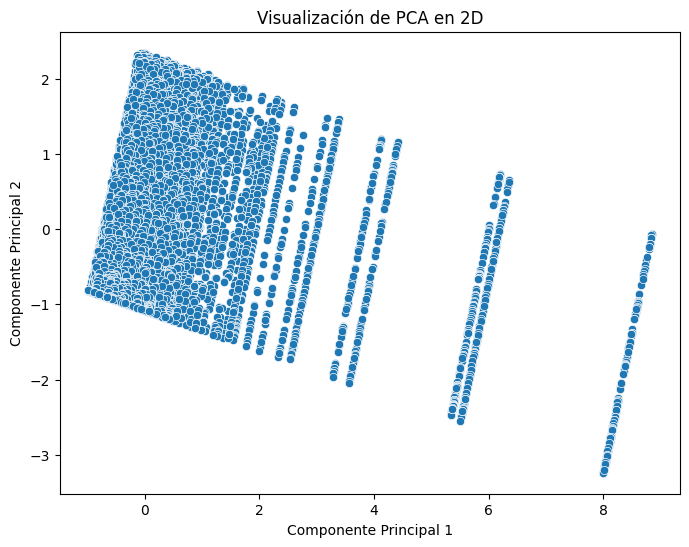

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un scatter plot de las dos primeras componentes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], palette="coolwarm")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("Visualización de PCA en 2D")
plt.show()



In [83]:
results2 = dict()

## **Aglomerative PCA**

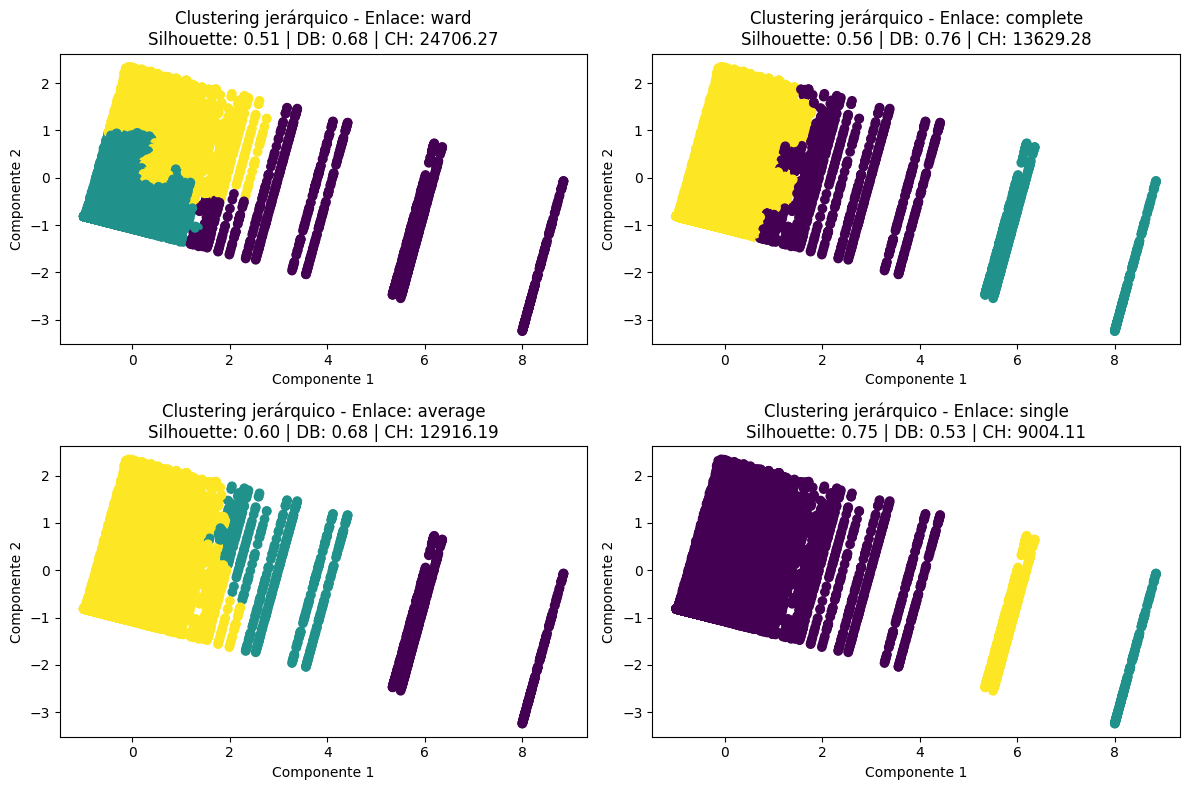

In [84]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score



# Seleccionar las columnas relevantes para el clustering jerárquico
X = df_pca

# Crear lista de métodos de enlace
linkage_methods = ['ward', 'complete', 'average', 'single']

# Configurar la visualización
plt.figure(figsize=(12, 8))

# Iterar sobre los métodos de enlace y realizar clustering jerárquico
for i, method in enumerate(linkage_methods):
    # Realizar clustering jerárquico con el método de enlace actual
    clustering = AgglomerativeClustering(n_clusters=3, linkage=method)
    labels = clustering.fit_predict(X)
    sc = silhouette_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    results2[f'Clustering jerárquico - Enlace: {method}'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}

    # Graficar los puntos en un diagrama de dispersión para las dos primeras columnas
    plt.subplot(2, 2, i+1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.title(f'Clustering jerárquico - Enlace: {method}\nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')




plt.tight_layout()
plt.show()

## **K MEANS**

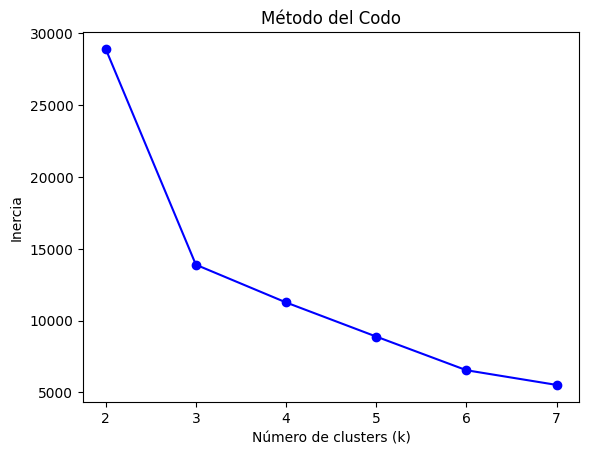

In [ ]:


# Definir una lista de posibles valores de k para el método del codo
k_values = range(2, 8)

# Inicializar listas para almacenar las métricas
inertia_values = []

# Realizar clustering con diferentes valores de k y calcular las métricas
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    labels = kmeans.labels_
    # Calcular la inercia
    inertia_values.append(kmeans.inertia_)
    

# Graficar el método del codo utilizando la inercia
plt.plot(k_values, inertia_values, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.show()

/tmp/ipykernel_167290/595649355.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Cluster_KMEANS_pca'] = kmeans.fit_predict(df_pca)


['Cluster 0', 'Cluster 2', 'Cluster 1']


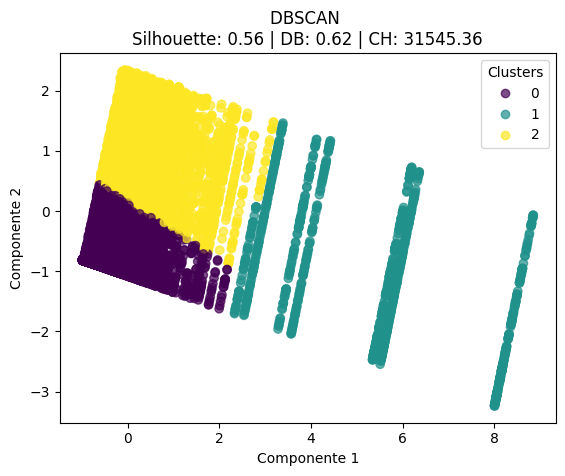

In [85]:
# Aplicar algoritmos de clustering (por ejemplo, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
df_filtrado['Cluster_KMEANS_pca'] = kmeans.fit_predict(df_pca)
sc = silhouette_score(X, df_filtrado['Cluster_KMEANS_pca'] )
db_index = davies_bouldin_score(X, df_filtrado['Cluster_KMEANS_pca'] )
ch_index = calinski_harabasz_score(X, df_filtrado['Cluster_KMEANS_pca'] )
results2[f'Clustering KMEANS'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}


# Visualizar los resultados
scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=df_filtrado['Cluster_KMEANS_pca'], cmap='viridis', alpha=0.7)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title(f'DBSCAN \nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')

# Obtener etiquetas únicas de los clusters
unique_labels = df_filtrado['Cluster_KMEANS_pca'].unique()

# Generar etiquetas para la leyenda
legend_labels = [f'Cluster {label}' for label in unique_labels]
print(legend_labels)
# Agregar leyenda
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


## **PROBANDO DBSCAN CON PCA**

/tmp/ipykernel_167290/1610981330.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["Cluster_DBSCAN_pca"] = dbscan.fit_predict(df_pca)


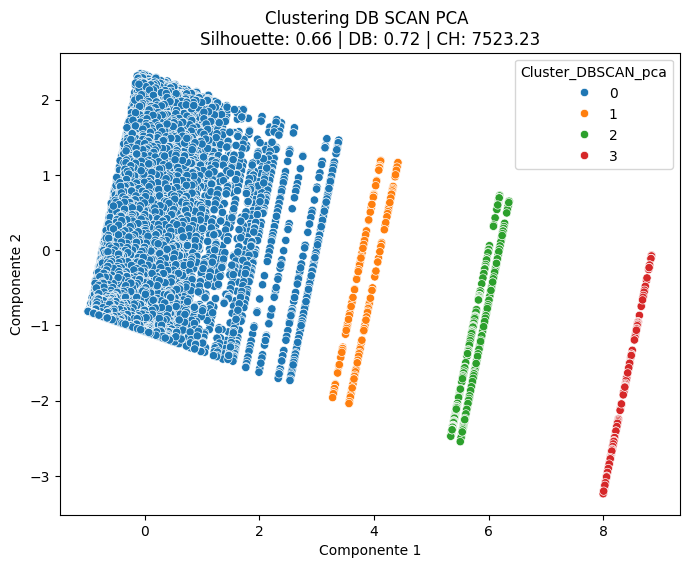

In [87]:

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajusta eps y min_samples según sea necesario
df_filtrado["Cluster_DBSCAN_pca"] = dbscan.fit_predict(df_pca)


sc = silhouette_score(X, df_filtrado['Cluster_DBSCAN_pca'] )
db_index = davies_bouldin_score(X, df_filtrado['Cluster_DBSCAN_pca'] )
ch_index = calinski_harabasz_score(X, df_filtrado['Cluster_DBSCAN_pca'] )
results2[f'Clustering DBSCAN'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}


# Visualizar los resultados
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=df_filtrado["Cluster_DBSCAN_pca"], palette="tab10", legend="full")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("DBSCAN")
plt.title(f'Clustering DB SCAN PCA \nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')
plt.show()

                                                                                                                                                    
- Mejora más de 10% en relación al la otra clusterización. Con esto podemos ver que DBSCAN es un modelo que podriamos ajustar sus hiperparámetros

In [ ]:


# Definir rangos para eps y min_samples
eps_range = np.arange(0.1, 1.0, 0.1)  # Valores de eps
min_samples_range = range(3, 11)      # Valores de min_samples

# Variables para almacenar los mejores parámetros
best_score = -1
best_params = {"eps": None, "min_samples": None}

# GridSearch manual
for eps in eps_range:
    for min_samples in min_samples_range:
        # Aplicar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_pca)
        
        # Ignorar configuraciones con un único clúster o todos ruido
        if len(set(labels)) <= 1 or (labels == -1).mean() == 1.0:
            continue
        
        # Calcular Silhouette Score
        score = silhouette_score(df_pca, labels)
        
        # Guardar si es el mejor hasta ahora
        if score > best_score:
            best_score = score
            best_params = {"eps": eps, "min_samples": min_samples}

# Resultados
print("Mejor Silhouette Score:", best_score)
print("Mejores parámetros:", best_params)

Mejor Silhouette Score: 0.7518194131148838
Mejores parámetros: {'eps': np.float64(0.8), 'min_samples': 3}


/tmp/ipykernel_167290/1298773933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["Cluster_DBSCAN_pca_BEST"] = dbscan.fit_predict(df_pca)


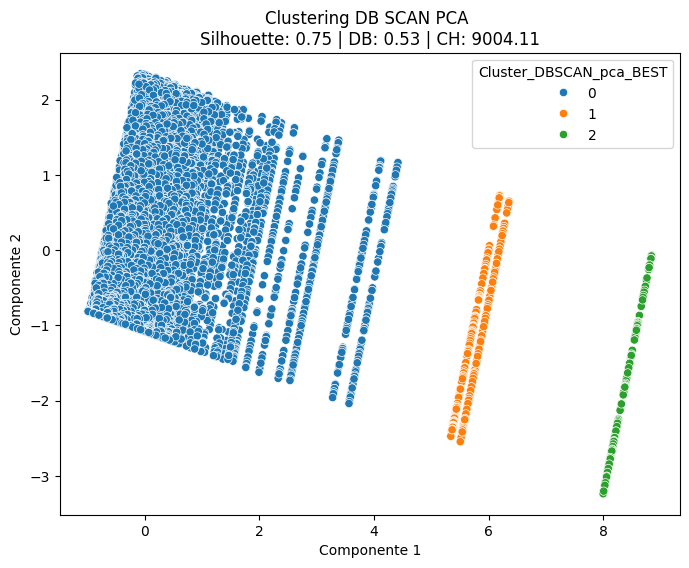

In [88]:

# Crear el modelo DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=3)  # Ajusta eps y min_samples según sea necesario
df_filtrado["Cluster_DBSCAN_pca_BEST"] = dbscan.fit_predict(df_pca)


sc = silhouette_score(X, df_filtrado['Cluster_DBSCAN_pca_BEST'] )
db_index = davies_bouldin_score(X, df_filtrado['Cluster_DBSCAN_pca_BEST'] )
ch_index = calinski_harabasz_score(X, df_filtrado['Cluster_DBSCAN_pca_BEST'] )
results2[f'Cluster_DBSCAN_pca_BEST'] = {'silhoutte_score':sc, 'davies_bouldin_score':db_index, 'calinski_score':ch_index}


# Visualizar los resultados
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pca.iloc[:, 0], y=df_pca.iloc[:, 1], hue=df_filtrado["Cluster_DBSCAN_pca_BEST"], palette="tab10", legend="full")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("DBSCAN")
plt.title(f'Clustering DB SCAN PCA \nSilhouette: {sc:.2f} | DB: {db_index:.2f} | CH: {ch_index:.2f}')
plt.show()

## **RESUMEN MODELOS**

In [90]:
df_pca_resumen = pd.DataFrame(results2)

df_pca_resumen

,Clustering jerárquico - Enlace: ward,Clustering jerárquico - Enlace: complete,Clustering jerárquico - Enlace: average,Clustering jerárquico - Enlace: single,Clustering KMEANS,Clustering DBSCAN,Cluster_DBSCAN_pca_BEST
silhoutte_score,0.514604,0.561528,0.603805,0.751819,0.558720,0.658491,0.751819
davies_bouldin_score,0.677359,0.757264,0.675091,0.533465,0.621365,0.720191,0.533465
calinski_score,24706.274238,13629.277729,12916.187825,9004.107097,31545.355197,7523.234779,9004.107097


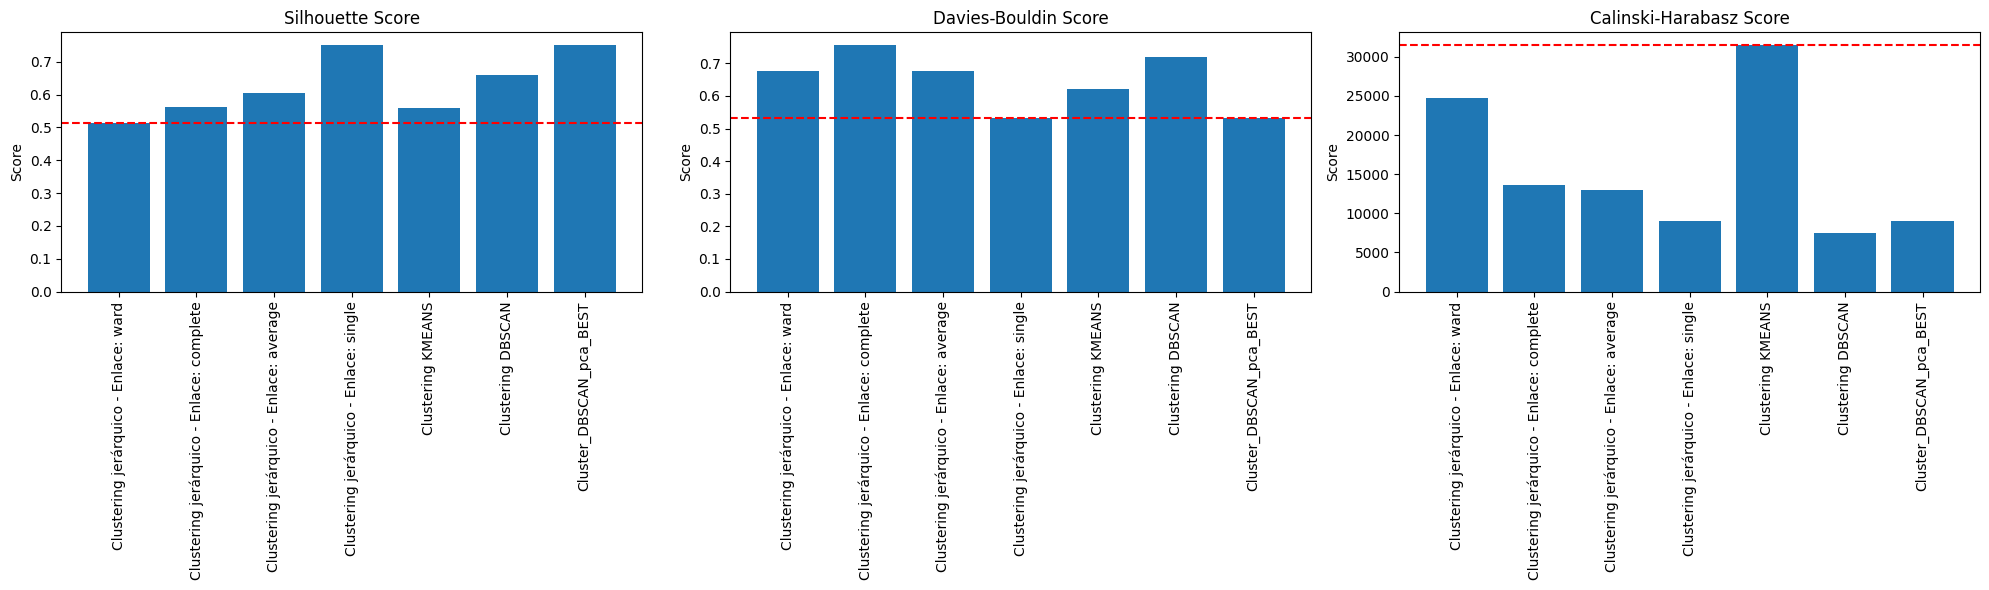

In [91]:
# Crear subplots para cada métrica
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico para Silhouette Score
axs[0].bar(df_pca_resumen.columns, df_pca_resumen.loc['silhoutte_score'])
axs[0].set_title('Silhouette Score')
axs[0].axhline(df_pca_resumen.loc['silhoutte_score'].min(), linestyle='--', color='r')
axs[0].tick_params(axis='x', rotation=90)
axs[0].set_ylabel('Score')

# Gráfico para Davies-Bouldin Score
axs[1].bar(df_pca_resumen.columns, df_pca_resumen.loc['davies_bouldin_score'])
axs[1].set_title('Davies-Bouldin Score')
axs[1].axhline(df_pca_resumen.loc['davies_bouldin_score'].min(), linestyle='--', color='r')
axs[1].tick_params(axis='x', rotation=90)
axs[1].set_ylabel('Score')

# Gráfico para Calinski-Harabasz Score
axs[2].bar(df_pca_resumen.columns, df_pca_resumen.loc['calinski_score'])
axs[2].set_title('Calinski-Harabasz Score')
axs[2].axhline(df_pca_resumen.loc['calinski_score'].max(), linestyle='--', color='r')

axs[2].tick_params(axis='x', rotation=90)
axs[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

In [92]:
df["Cluster_DBSCAN_pca_BEST"] = df_filtrado["Cluster_DBSCAN_pca_BEST"] 

## **Perfilado**

In [93]:
# Agrupar los datos por cluster y calcular estadísticas descriptivas
estadisticas_clusters = df.groupby('Cluster_DBSCAN_pca_BEST').agg({
    'Recencia': ['mean', 'median', 'min', 'max'],
    'Frecuencia': ['mean', 'median', 'min', 'max'],
    'Monto': ['mean', 'median', 'min', 'max']
})

# Mostrar las estadísticas
print("Estadísticas descriptivas por cluster:")
estadisticas_clusters

Estadísticas descriptivas por cluster:


Recencia                  Frecuencia              \
                               mean median min  max        mean median  min   
Cluster_DBSCAN_pca_BEST                                                       
0                        116.263599   87.0   0  373   14.036812    8.0    1   
1                        163.336870  155.0   0  373  190.952255  210.0  167   
2                        133.679348   99.0   0  369  184.000000  184.0  184   

                                     Monto                                
                         max          mean    median       min       max  
Cluster_DBSCAN_pca_BEST                                                   
0                        127   3444.715577   1908.25      1.25  32561.82  
1                        210  32671.578064  26966.61  26966.61  39845.49  
2                        184  66879.230000  66879.23  66879.23  66879.23

In [94]:
# Obtener el total de clientes
total_clientes = len(df)

# Calcular la cantidad y porcentaje de clientes por cluster
porcentaje_por_cluster = df['Cluster_DBSCAN_pca_BEST'].value_counts(normalize=True) * 100
cantidad_por_cluster = df['Cluster_DBSCAN_pca_BEST'].value_counts()

# Mostrar los resultados
print("Cantidad de clientes por cluster:")
cantidad_por_cluster.to_frame('Cantidad_total')


Cantidad de clientes por cluster:


,Cantidad_total
Cluster_DBSCAN_pca_BEST,
0,19450
1,377
2,184


In [ ]:
print("\nPorcentaje de clientes por cluster:")
porcentaje_por_cluster.to_frame('Porcentaje')


Porcentaje de clientes por cluster:


,Porcentaje
Cluster_DBSCAN_pca_BEST,
0,97.196542
1,1.883964
2,0.919494


In [ ]:
# Suma del monto total por cluster
monto_por_cluster = df.groupby('Cluster_DBSCAN_pca_BEST')['Monto'].sum()

# Monto total de todos los clusters
monto_total = monto_por_cluster.sum()

# Porcentaje del monto total por cluster
porcentaje_monto_por_cluster = (monto_por_cluster / monto_total) * 100


print("Porcentaje del monto total por cluster:")
porcentaje_monto_por_cluster


Porcentaje del monto total por cluster:


Cluster_DBSCAN_pca_BEST
0    73.12569
1    13.44338
2    13.43093
Name: Monto, dtype: float64


#### CLUSTER 0:

Corresponden a la mayoria de los clientes (97%). En general son clientes que se demoran en comprar o ya están inactivos.  Además esto se complementa que son los que compran menos veces y además con menores montos. Aún asi son de gran importancia ya que representan la mayoria de los clientes por lo que son top prioridad.

#### CLUSTER 1:

En cantidad son casi el 2% de los clientes. Estos si bien tienen una recencia más alta que el cluster 0 se caracterizan por una frecuencia de compra mucho más alta además de montos significativamente más altos.


#### CLUSTER 2:

Son los clientes minoritarios pero corresponden a aquellos clientes con la mayor fuerza monetaria para la empresa. Estos duplican al cluster 1 en cuanto al monto promedio.





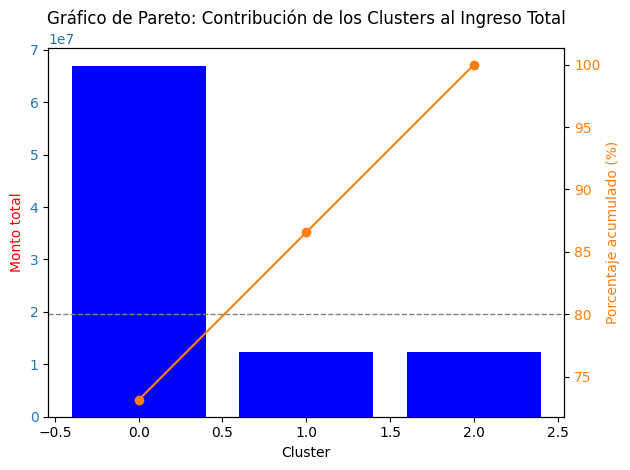

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Calcular monto total por cluster
monto_por_cluster = df.groupby('Cluster_DBSCAN_pca_BEST')['Monto'].sum().sort_values(ascending=False)

# Calcular porcentaje acumulativo
porcentaje_acumulado = monto_por_cluster.cumsum() / monto_por_cluster.sum() * 100

# Crear el gráfico de Pareto
fig, ax1 = plt.subplots()

# Gráfico de barras para el monto total
ax1.bar(monto_por_cluster.index, monto_por_cluster, color='b')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Monto total', color='r')
ax1.tick_params(axis='y', labelcolor='C0')

# Línea para el porcentaje acumulado
ax2 = ax1.twinx()
ax2.plot(monto_por_cluster.index, porcentaje_acumulado, color='C1', marker='o', linestyle='-')
ax2.set_ylabel('Porcentaje acumulado (%)', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# Agregar una línea horizontal al 80%
ax2.axhline(80, color='gray', linestyle='--', linewidth=1)

# Títulos y leyenda
plt.title('Gráfico de Pareto: Contribución de los Clusters al Ingreso Total')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


## CONCLUSIONES:

Considerando lo anterior pordemos agrupos los clientes en tres nuevas categorias:

- **Cluster 0 : CLIENTES OCACIONALES**

    - Aumentar la frecuencia de compra de estos clientes parece de gran importancia además de tratar de fidelizar a estos generando que compren mayores montos. Son la fuerza más grande dentro del total de ingresos asi que su prioridad es máxima.

- **Cluster 1 : CLIENTES FRECUENTES**

    - Incentivar la compra de productos con gran margen seria una buena idea o implementar programas para estimular su interes en seguir comprando. 

- **Cluster 2: CLIENTES VIP**

    - Estos clientes al igual que los anteriores si o si se deben mantener por lo que beneficios especiales para estos es prioritario.


In [ ]:
df['TIPO_CLIENTE'] = df['Cluster_DBSCAN_pca_BEST'].replace({0:'CLIENTES OCACIONALES', 1:'CLIENTES_FRECUENTES', 2:'CLIENTES VIP'})

In [ ]:
df

,Quantity,price_total,StockCode,price_total_log,Quantity_log,Recencia,Frecuencia,Monto,Cluster_DBSCAN_pca_BEST,TIPO_CLIENTE
0,40,139.12,7,4.942499,3.713572,71,19,4678.67,0,CLIENTES OCACIONALES
1,12,22.20,2,3.144152,2.564949,71,19,4678.67,0,CLIENTES OCACIONALES
2,83,278.73,12,5.633825,4.430817,342,18,3395.98,0,CLIENTES OCACIONALES
3,15,70.05,4,4.263384,2.772589,342,18,3395.98,0,CLIENTES OCACIONALES
4,3,17.85,1,2.936513,1.386294,342,18,3395.98,0,CLIENTES OCACIONALES
...,...,...,...,...,...,...,...,...,...,...
20006,4,8.32,1,2.232163,1.609438,0,12,1456.15,0,CLIENTES OCACIONALES
20007,23,32.53,2,3.512441,3.178054,0,23,2669.24,0,CLIENTES OCACIONALES
20008,1,224.69,1,5.419162,0.693147,0,32,10040.23,0,CLIENTES OCACIONALES
20009,5,54.75,1,4.020877,1.791759,0,99,32561.82,0,CLIENTES OCACIONALES


Según nuestro gráfico se observa que los clientes ocacionales debido a su cantidad, generan la mayoria de los ingresos en nuestros datos un 75% del total, los otros dos clusters generan el resto. ESto es interesante porque consideramos que los clientes de gran importancia podrian ser los clientes frecuentes o vip, pero considerando este gráfico mantener o incentibar a esta gran masa parece una aún mejor estrategia para seguir teniendo ventas altas. Esto no quiere decir que dejemos de lado los otras clasificaciones de clientes pero debido a que en este negocio la cantidad es demasiado alta parece ser importante mirar bien a los clientes mas ocacionales ya que son la masa que mueve las ganancias de la empresa

## GUARDANDO LO NECESARIO PARA REPRODUCIBILIDAD

In [ ]:
import joblib

# Guardar el modelo PCA
joblib.dump(pca, 'modelo_pca.pkl')

# Guardar el modelo DBSCAN
joblib.dump(dbscan, 'modelo_dbscan.pkl')

print("Modelos guardados exitosamente.")


Modelos guardados exitosamente.
